In [0]:
## install

# !pip install gym[atari]

In [0]:
## setup

import gym

import numpy as np
from matplotlib import pyplot as plt
import random
from IPython.display import clear_output
from time import sleep
import time
import pickle
from google.colab import files

# neural network
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import tensorflow as tf

# video
import imageio
# embed video to notebook
import base64
# interactive architecture for jupyter notebook
import IPython

In [0]:
## hyperparameter

MAX_STEP = 300
MAX_LENGTH_REPLAY = 10000
VIDEO_NAME_RANDOM = 'random_agent.mp4'
HEIGHT = 210
WIDTH = 160
CHANNEL = 3
N_OUT = 6
LEARNING_RATE = 0.001 # learning rate in neural network optimizer
GAMMA = 0.99 # discount factor
EPSILON = 1.0
EPSILON_MIN = 0.1
EPSILON_DECAY = 0.999
EPSILON_EVAL = 0.01 # epsilon-greedy method in evaluation environment
BATCH_SIZE = 32
TIME_STEP = 200
MODEL_PATH = 'model.h5'
FIGURE_PATH = 'dqn_reward.png'
REWARD_PATH = 'rewards.sav'
VIDEO_PATH = 'dqn_v1.mp4'

EPISODES = 10
MONITOR_INTERVAL = 1
EVAL_STEP = 400
EVAL_EPISODES = 1

action space Discrete(6)
meaning of action space ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
observation space Box(210, 160, 3)


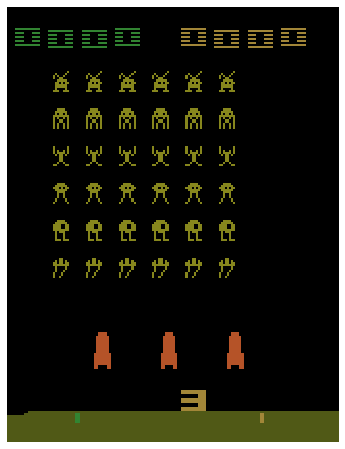

In [46]:
## environment

env = gym.make('SpaceInvaders-v0')
env.reset()

# show spec
# Discrete(6) but action index includes 0, 1, 2, 3, 4, 5
print("action space", env.action_space)
print("meaning of action space", env.get_action_meanings())
print("observation space", env.observation_space)

# show environment
plt.figure(figsize = (8, 8))
plt.imshow(env.render('rgb_array'))
plt.axis('off')
plt.show()

In [0]:
## experience replay

class Replay:
    def __init__(self):
        self.buffer = []
        self.length = 0
        self.max_length = MAX_LENGTH_REPLAY

    def write(self, data):
        # if replay is full, delete the oldest (first list) and append the new
        if self.length >= self.max_length:
            self.buffer.pop(0)
            self.length -= 1
        self.buffer.append(data)
        self.length += 1

    def read(self, batch_size):
        # at beginning buffer is almost empty, so batch is smaller than batch_size
        # random.sample is k sample from population without replacement
        return random.sample(population = self.buffer, k = min(batch_size, self.length))

In [0]:
## network

class Network:
    def __init__(self, height, width, channel, n_out):
        self.height = height
        self.width = width
        self.channel = channel
        self.n_out = n_out

    def _build_model(self):
        model = Sequential()
        model.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (self.height, self.width, self.channel,)))
        model.add(Conv2D(32, (3, 3), activation = 'relu'))
        model.add(MaxPooling2D(pool_size = (2, 2)))
        model.add(Flatten())
        model.add(Dense(32, activation = 'relu'))
        model.add(Dense(self.n_out, activation = 'linear'))
        optimizer = tf.keras.optimizers.RMSprop(LEARNING_RATE)
        model.compile(loss = 'mse', optimizer = optimizer)
        return model

In [0]:
## agent

class Agent:
    def __init__(self):
        self.height = HEIGHT
        self.width = WIDTH
        self.channel = CHANNEL
        self.n_out = N_OUT
        self.total_reward = 0
        self.gamma = GAMMA # discount factor
        self.epsilon = EPSILON
        self.epsilon_min = EPSILON_MIN
        self.epsilon_decay = EPSILON_DECAY
        self.batch_size = BATCH_SIZE
        self.replay_buffer = Replay()
        self.model = Network(self.height, self.width, self.channel, self.n_out)._build_model()

    def gather_experience(self, last_state, action, reward, state):
        self.replay_buffer.write((last_state, action, reward, state))

    def set_total_reward(self, new_total):
        self.total_reward = new_total

    def gather_reward(self, reward):
        self.total_reward += reward

    def get_total_reward(self):
        return self.total_reward

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def reshape_state(self, state):
        return np.reshape(state, (-1, self.height, self.width, self.channel))

    def choose_action(self, state):
        if np.random.rand() > self.epsilon:
            state = self.reshape_state(state)
            return np.argmax(self.model.predict(state)[0])
        else:
            return np.random.randint(low = 0, high = self.n_out - 1, size = None, dtype = 'int')

    def update_q(self):
        batch = self.replay_buffer.read(self.batch_size)
        n = len(batch)

        x_batch = np.zeros([n, self.height, self.width, self.channel])
        y_batch = np.zeros([n, self.n_out])

        i = 0

        for b in batch:
            last_state, action, reward, state = b
            last_state = self.reshape_state(last_state)
            q_last = self.model.predict(last_state)[0]

            if state is None:
                q_last[action] = reward
            else:
                state = self.reshape_state(state)
                q_this = self.model.predict(state)[0]
                y = reward + self.gamma * np.max(q_this)
                q_last[action] = y
            
            x_batch[i, :] = last_state
            y_batch[i, :] = q_last
            i + 1
        
        history = self.model.fit(x_batch, y_batch, epochs = 1, verbose = 0)

        return history.history['loss'][0]

episode:0, reward:40.0, epsilon:0.999, time:32.0
episode:1, reward:35.0, epsilon:0.998, time:66.0
episode:2, reward:35.0, epsilon:0.997, time:100.0
episode:3, reward:65.0, epsilon:0.99601, time:133.0
episode:4, reward:50.0, epsilon:0.99501, time:167.0
episode:5, reward:35.0, epsilon:0.99401, time:201.0
episode:6, reward:45.0, epsilon:0.99302, time:234.0
episode:7, reward:60.0, epsilon:0.99203, time:268.0
episode:8, reward:25.0, epsilon:0.99104, time:301.0
episode:9, reward:20.0, epsilon:0.99004, time:335.0


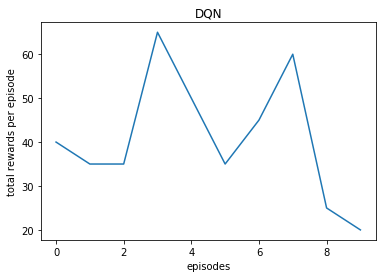

FileNotFoundError: ignored

In [50]:
## training

agent = Agent()
ep_rewards = []
loss = False
losses = []
start_time = time.time()

for ep in range(EPISODES):
    last_state = env.reset()
    agent.set_total_reward(0)

    for t in range(TIME_STEP):
        action = agent.choose_action(last_state)
        state, reward, done, info = env.step(action)

        if done == True:
            state = None

        agent.gather_reward(reward)
        agent.gather_experience(last_state, action, reward, state)

        loss = agent.update_q()

        last_state = state

        if done == True:
            ep_rewards.append(agent.get_total_reward())
            break

    if done == False:
        ep_rewards.append(agent.get_total_reward())

    if loss:
        losses.append(loss)

    agent.decay_epsilon()

    # monitoring
    if ep % MONITOR_INTERVAL == 0:
        print("episode:{}, reward:{}, epsilon:{}, time:{}".format(ep, 
                                                                  agent.get_total_reward(),
                                                                  np.round(agent.epsilon, decimals = 5),
                                                                  np.round(time.time() - start_time, decimals = 0)))
        
agent.model.save(MODEL_PATH)

episode = range(0, EPISODES, 1)
plt.plot(episode, ep_rewards)
plt.ylabel("total rewards per episode")
plt.xlabel("episodes")
plt.title("DQN")
plt.savefig(FIGURE_PATH)
plt.show()
pickle.dump(ep_rewards, open(REWARD_PATH))

step:113, action:5, reward:0.0, done:False


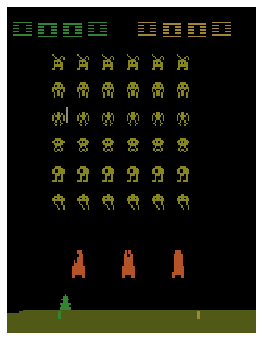

KeyboardInterrupt: ignored

In [55]:
## evaluation picture story show

eval_model = load_model(MODEL_PATH)

state = env.reset()

for i in range(EVAL_STEP):
    clear_output(wait = True)

    if np.random.rand() > EPSILON_EVAL:
        state = np.reshape(state, (-1, HEIGHT, WIDTH, CHANNEL))
        action = np.argmax(eval_model.predict(state)[0])
    else:
        action = np.random.randint(low = 0, high = N_OUT - 1, size = None, dtype = 'int')

    next_state, reward, done, info = env.step(action)
    
    plt.figure(figsize = (6, 6))
    plt.imshow(next_state)
    plt.axis('off')

    print("step:{}, action:{}, reward:{}, done:{}".format(i, action, reward, done))
    plt.show()
    sleep(.5)

In [59]:
## evaluation video

"""
this code outputs mp4 file. 
If you run this in your local PC, video file will be saved in your local directory.
If it's Colab, the video file 
"""

eval_model = load_model(MODEL_PATH)

# what's this?
fps = 30

with imageio.get_writer(VIDEO_PATH, fps = fps) as video:
    for _ in range(EVAL_EPISODES):
        # initialize
        state = env.reset()
        done = False
        video.append_data(env.render('rgb_array'))
        
        # start episode
        while not done:
            if np.random.rand() > EPSILON_EVAL:
                state = np.reshape(state, (-1, HEIGHT, WIDTH, CHANNEL))
                action = np.argmax(eval_model.predict(state)[0])
            else:
                action = np.random.randint(low = 0, high = N_OUT - 1, size = None, dtype = 'int')

            # get next state
            next_state, reward, done, info = env.step(action)
            video.append_data(env.render('rgb_array'))

            # iteration
            state = next_state

In [0]:
# ## debug plot

# episode = range(0, EPISODES, 1)
# print(len(episode))
# print(len(ep_rewards))
# print(ep_rewards)

# episode = range(0, EPISODES, 1)
# plt.plot(episode, ep_rewards)
# plt.ylabel("total rewards per episode")
# plt.xlabel("episodes")
# plt.title("DQN")
# plt.savefig(FIGURE_PATH)
# plt.show()

In [0]:
# ## debug model prediction

# tmp = env.reset()
# print("input shape:", tmp.shape)

# model = Network(height = HEIGHT, width = WIDTH, channel = CHANNEL, n_out = N_OUT)._build_model()
# print(model.summary())

# tmp = np.reshape(tmp, (-1, HEIGHT, WIDTH, CHANNEL))
# print(tmp.shape)

# pred = model.predict(tmp)[0]
# print(pred)

In [0]:
# ## random policy

# # initialize
# state = env.reset()
# action = 0

# for i in range(MAX_STEP):
#     clear_output(wait = True)

#     next_state, reward, done, info = env.step(action)
#     # draw random action
#     action = np.random.randint(low = 0, high = 5, size = None, dtype = 'int')

#     plt.figure(figsize = (6, 6))
#     plt.imshow(next_state)
#     plt.axis('off')
#     print("step:{}, action:{}, reward:{}, done:{}".format(i, action, reward, done))
#     plt.show()
#     sleep(.5)

In [0]:
# ## make mp4 video file

# """
# this code outputs mp4 file. 
# If you run this in your local PC, video file will be saved in your local directory.
# If it's Colab, the video file 
# """

# # what's this?
# fps = 30
# num_episodes = 1

# with imageio.get_writer(VIDEO_NAME_RANDOM, fps = fps) as video:
#     for _ in range(num_episodes):
#         # initialize
#         time_step = env.reset()
#         done = False
#         video.append_data(env.render('rgb_array'))
        
#         # start episode
#         while not done:
#             # draw random action
#             action = np.random.randint(low = 0, high = 5, size = None, dtype = 'int')
#             # get next state
#             next_state, reward, done, info = env.step(action)
#             video.append_data(env.render('rgb_array'))

# # files.download(VIDEO_NAME_RANDOM)  

In [0]:
# ## embed video in this notebook

# video = open(VIDEO_NAME_RANDOM, 'rb').read()
# print("Type of video:", type(video))
# print("Length of video file:", len(video))

# # encode a string using Base64, returns encoded string, used to generate URL
# b64 = base64.b64encode(video)
# # print("b64encode:", b64)

# tag = '''
#       <video width = "640" height = "480" controls>
#           <source src = "data:video/mp4; base64, {0}" type = "video/mp4">
#       Your browser does not support the video tag.
#       </video>
#       '''.format(b64.decode())

# # print("tag:", tag)

# IPython.display.HTML(tag)